### Data Augmentations for Selective Class

In [14]:
import os
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
#from helpers import visualize
%matplotlib inline

In [15]:
def visualize(input_arr,labels,num_imgs=9):
    plot_size=int(np.ceil(num_imgs/4))
    fig = plt.figure(figsize=(12,12))
    if len(input_arr.shape)==4:
        num_imgs=input_arr.shape[0]
    else:
        num_imgs=1
        input_arr=np.expand_dims(input_arr,axis=0)
        labels=[labels]
    for i in range(num_imgs):
      plt.subplot(4,plot_size,i+1)
      plt.tight_layout()
      img = input_arr[i]

      img = np.rollaxis(img,0,3)
      plt.imshow(img, interpolation='none')
      plt.title("class_label: {}".format(labels[i]))
      plt.xticks([])
      plt.yticks([])

In [16]:
from torch.utils.data.dataloader import default_collate


In [17]:
class DatasetLoader_2(Dataset):
    """ Tire Dataset Class Wrapper """

    def __init__(self, root_path, data_dir, annotation_file,data_type='train', \
                 data_transform=None,label_transform=None):
        """
        Args:
            root_path (string):  the parent folder path
            annotation_file (string):  csv/txt file which has the 
                                        dataset labels
            data_type(string): the type of data-train,val,test
            data_transform: The trasforms to apply to data
            label_transform: The transforms to apply to label

        """
        
        self.data_path = os.path.join(root_path,data_dir,data_type)
        self.label_path = os.path.join(root_path,annotation_file)
        self.data_transform = data_transform
        self._load_data()
        
    def _load_data(self):
        '''
        function to load the data in the format of [[img_name_1,label_1],
        [img_name_2,label_2],.....[img_name_n,label_n]]
        '''
        self.labels = pd.read_csv(self.label_path)
        
        self.loaded_data = []
        for i in range(self.labels.shape[0]):
            img_name = os.path.join(self.data_path, self.labels['img_names'][i])
            label = self.labels['labels'][i]
            self.loaded_data.append((img_name,label))

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):

        idx = idx % len(self.loaded_data)
       
        img_name,label = self.loaded_data[idx]    
        
        img = Image.open(img_name)
        
        if type(self.data_transform)==list:
            data=[]
            labels=[]
            if label==0:
                for tfm in self.data_transform:
                    img_ = tfm(img.copy())
                    data.append(img_)
                    labels.append(label)
                data=torch.stack(data, dim=0)
                labels = torch.LongTensor(labels)
                return data,labels
            else:
                img_=self.data_transform[0](img.copy())
                channels, height, width = img_.size()
                img_=img_.view([1,channels, height, width])
                return img_,torch.LongTensor([label])
        else:
            img_ = self.data_transform(img.copy())        
            return img_,label

In [18]:
root_path=r'D:\youtube\2021\data_aug_pytorch'
data_dir='dogs-vs-cats'
annotation_file='train_labels_imbalanced.csv'


In [19]:
t0=transforms.Compose([transforms.Resize((128,128)),
                                        transforms.ToTensor()])
t1=transforms.Compose([t0,transforms.RandomPerspective(distortion_scale=0.4, p=1.0)])
#t2=transforms.Compose([transforms.Resize((128,128)),transforms.RandomCrop(96),t0])
#t3=transforms.Compose([t0,transforms.RandomRotation((0,180))])

transform_tr=[t0,t1]

In [20]:
training_dataset=DatasetLoader_2(root_path,data_dir,annotation_file,data_type='train',\
                          data_transform=transform_tr)
print('length of dataset: ', len(training_dataset))

length of dataset:  150


torch.Size([1, 3, 128, 128]) tensor([1])


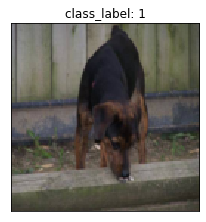

In [22]:
img,label=training_dataset[100]
print(img.shape,label)
visualize(img.numpy(),label,num_imgs=1)

In [23]:
train_dataloader = DataLoader(training_dataset,collate_fn=default_collate, batch_size=12, shuffle=True)

In [24]:
data,label=next(iter(train_dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [1, 3, 128, 128] at entry 0 and [2, 3, 128, 128] at entry 1

In [25]:
def my_collate_func_2(batch):
    
    #print(batch[1])
    data=[item[0] for item in batch]
    label=[item[1] for item in batch]
   # print('label: ',label)
    data=torch.cat(data,dim=0)
    label=torch.cat(label,dim=0)
    return [data,label]


In [26]:
train_dataloader = DataLoader(training_dataset,collate_fn=my_collate_func_2, batch_size=12, shuffle=True)

In [27]:
data,label=next(iter(train_dataloader))
print(data.shape,label.shape)

torch.Size([15, 3, 128, 128]) torch.Size([15])


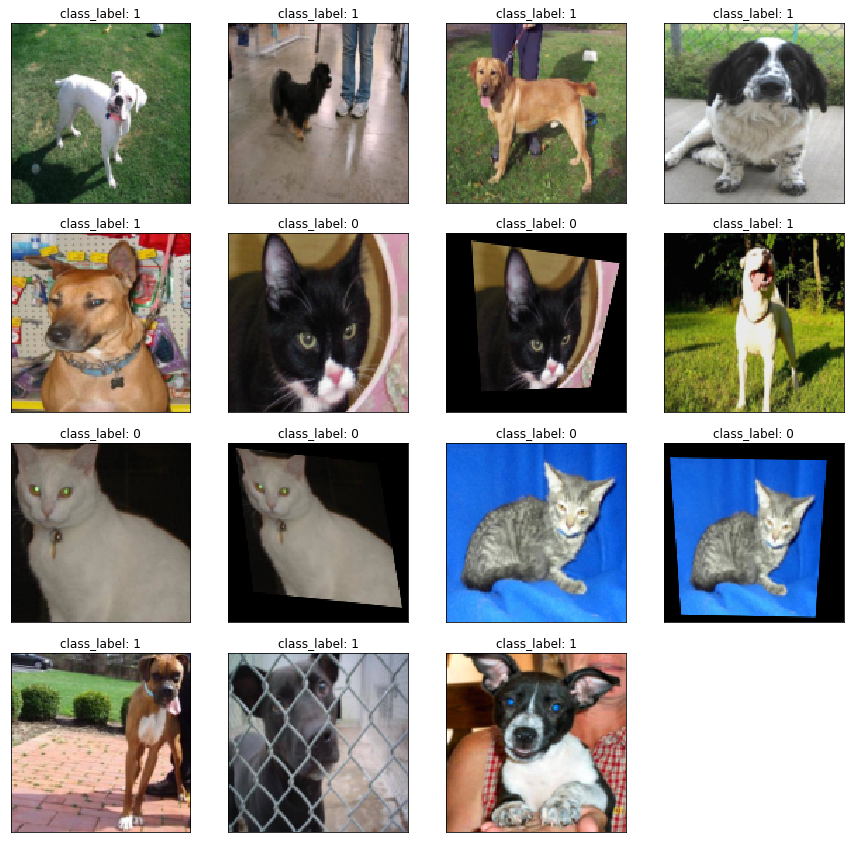

In [28]:
visualize(data.numpy(),label,num_imgs=data.shape[0])